In [175]:
import pandas as pd
import numpy as np
import csv
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Exercise  1: Backward search for variable selection

In [202]:
# Load the data into pandas Dataframe

bank_df = pd.read_csv("bank/bank-full.csv", sep = ';', header='infer')

### Handling missing values/unknown values

- Dropping columns = ['contact','poutcome','pdays'], because about 1/3rd rows have 'unknown' ```contact``` and more than 70%
have 'unknown' ```poutcome```. Since, we cannot drop these many rows, we will drop these columns.

In [203]:
bank_df = bank_df.drop(['contact','poutcome', 'pdays'], axis=1)

- There are few number of rows with 'unknown' values for ['job', 'education']. They have been dropped.

In [204]:
bank_df = bank_df.drop(bank_df[bank_df['job']=='unknown'].index, axis=0)
bank_df = bank_df.drop(bank_df[bank_df['education']=='unknown'].index, axis=0)

In [205]:
bank_df.reset_index(drop=True, inplace=True)

### Convert non-numeric types to numeric

In [206]:
cat_columns = bank_df.select_dtypes(['object']).columns
cat_columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'month',
       'y'],
      dtype='object')

In [207]:
bank_df[cat_columns] = bank_df[cat_columns].apply(lambda x: pd.factorize(x)[0])

In [208]:
bank_df.isnull().any(axis=0).sum()

0

### Normalize and split dataset

In [209]:
## Mean Normalization of the data
scaler = MinMaxScaler()
bank_df = pd.DataFrame(scaler.fit_transform(bank_df),columns=bank_df.columns, index=bank_df.index)
#bank_df = bank_df.apply(lambda x: ( bank_df.mean(axis = 1) - x)/bank_df.std(axis=1))
train, test = train_test_split(bank_df, test_size=0.2, random_state=42, shuffle=True)
train_df = train.reset_index(drop=True)
test_df = test.reset_index(drop=True)

In [211]:
def prep_data(train_df, test_df, batch_size):
    '''
    Preparing train (creates a mini-batch) and tests for logistic regression algorithm
    '''
    train_df = train_df.sample(n=batch_size)
    
    Y = train_df['y']
    X = train_df.drop('y', axis=1)

    Y_test = test_df['y']
    X_test = test_df.drop('y', axis=1)

    X = X.to_numpy()
    Y = Y.to_numpy()

    Y = np.atleast_2d(Y).T

    X_test = X_test.to_numpy()
    Y_test = Y_test.to_numpy()

    Y_test = np.atleast_2d(Y_test).T

    X = np.hstack((np.atleast_2d(np.ones(len(X))).T, X))
    X_test = np.hstack((np.atleast_2d(np.ones(len(X_test))).T, X_test))
    
    return (X,Y,X_test,Y_test)

### Implementation of logistic regression with mini-batch Gradient Ascent

In [13]:
def learn_logreg_GA(train_df, test_df, step, tmax, params, batch_size, j):
    '''
    Implementation of logistic regression with gradient ascent algorithm (maximize log liklihood)
    Returns AIC score and param values of the model
    '''
    ## Delete the param provided in index j
    this_params = np.delete(params, np.s_[j], axis=0)
    
    for i in range(tmax):
        
        ## Get mini-batch of size batch_size
        (X,Y,X_test,Y_test) = prep_data(train_df, test_df, batch_size)
        
        # Delete the column from X also
        X = np.delete(X, np.s_[j], axis=1)
        
        interm_val = np.matmul(X,this_params)
        Y_hat = 1/(1+np.exp(-interm_val))
        
        gradient = np.matmul(X.T, (Y - Y_hat))
        
        # Update params
        this_params = this_params + step*gradient
    
    (X,Y,X_test,Y_test) = prep_data(train_df, test_df, train_df.shape[0])
    X = np.delete(X, np.s_[j], axis=1)
    
    # Computing log liklihood on complete training set, and compute AIC
    train_likli = np.sum(np.matmul(Y.T,np.matmul(X,this_params)) - np.log(1+np.exp(np.matmul(X,this_params))))
    AIC = train_likli - (len(this_params)-1)
    
    return (AIC, this_params)

### Implementation of Backward Search Procedure

In [14]:
def backward_search(train_df, test_df, step, tmax, params, batch_size):
    '''
    Find best set of parameters by running logistic regression iteratively and comparing AIC scores
    '''

    for i in range(6):
        ## Track of scores
        scores = []

        for j in range(1, len(params)):
            (score,this_params) = learn_logreg_GA(train_df, test_df, step, tmax, params, batch_size, j)
            scores.append(score)

        # Find param whose removal got maximum AIC
        ind = scores.index(max(scores))
        
        # Now train model with these parameters and get values of parameters
        (score, params) = learn_logreg_GA(train_df, test_df, step, tmax, params, batch_size, ind+1)
        
        print("Log liklihood on complete training set: ", score)


        # Drop the column from dataset as well
        train_df.drop(train_df.columns[[ind]], axis=1, inplace=True)
        test_df.drop(test_df.columns[[ind]], axis=1, inplace=True)

        # Compute error on test set with every iteration
        (X,Y,X_test,Y_test) = prep_data(train_df, test_df, batch_size)
        
        interm_val = np.matmul(X_test,params)
        Y_hat = 1/(1+np.exp(-interm_val))
        test_error = -np.mean((Y_test*np.log(Y_hat)) + (1-Y_test)*(np.log(1-Y_hat)))
        
        print("Log loss on test set:", test_error)
        
    print("Final set of columns in dataset after applying backward search:", train_df.columns)
    return

**Hyper-parameters used**
Batch Size : 500
Learning Rate: 0.0011
    


In [15]:
# length of parameter vector
num_param = train_df.shape[1]

# initializing parameter vector
params = np.zeros((num_param,1))

# Intializing steplength: alpha
step = 0.0011

# Initializing imax
tmax = 350

# Batch size
batch_size = 500

### Final error report on test set with every iteration of backward procedure

In [16]:
backward_search(train_df, test_df, step, tmax, params, batch_size) 

Log liklihood on complete training set:  -246411926.93414795
Log loss on test set: 0.32586305164161306
Log liklihood on complete training set:  -232931235.95422223
Log loss on test set: 0.3177380924929748
Log liklihood on complete training set:  -218543189.65801877
Log loss on test set: 0.3118410090857113
Log liklihood on complete training set:  -223222123.03355923
Log loss on test set: 0.3060565481159819
Log liklihood on complete training set:  -210230724.37418893
Log loss on test set: 0.3016183464336082
Log liklihood on complete training set:  -214417048.52979138
Log loss on test set: 0.29926114270379145
Final set of columns in dataset after applying backward search: Index(['education', 'default', 'housing', 'month', 'duration', 'campaign',
       'previous', 'y'],
      dtype='object')


**Final set of parameters are:**
['education', 'default', 'housing', 'month', 'duration', 'campaign','previous'] 

## Exercise 2 : Regularization for Logistic Regression

### Implementation of K fold Cross Validation 

In [10]:
def crossval_split(dataset,K,k):
    '''
    Splits dataset equally into K folds
    '''

    print("1")
    folds = list()
    dataCopy = list(dataset)
    print("2")
    foldSize = int(len(dataset) / K)

    for _ in range(K):
        fold = list()
        print("check")
        while len(fold) < foldSize:
            index = random.randrange(len(dataCopy))
            fold.append(dataCopy.pop(index))
            folds.append(fold)

    holdout = folds[k]
    trainSet = list(folds)
    trainSet.pop(k)
    trainSet = sum(trainSet, [])

    y_train = np.array([row[-1] for row in trainSet])
    X_train = np.array([train[:-1] for train in trainSet])
    y_test = np.array([row[-1] for row in holdout])
    X_test = np.array([test[:-1] for test in holdout])
    
    return X_train, y_train, X_test, y_test

### Implementation of regularized logistic regression

In [44]:
def learn_logreg_regularized(X,Y,X_test,Y_test, alpha, lamda, tmax):
    '''
    Implementation of regularized logistic regression with gradient ascent algorithm (maximize log liklihood)
    '''
    # initializing parameter vector
    params = np.zeros((len(X[0]),1))
    
    for i in range(tmax):
        
        # Do forward pass
        interm_val = np.matmul(X,params)
        Y_hat = 1/(1+np.exp(-interm_val))
        
        gradient = np.matmul(X.T, (Y - Y_hat)) - (2*lamda*params) ## the regularized term
        
        # Update params
        params = params + alpha*gradient
    
    
    ## Compute model accuracy on test set
    Y_pred = 1/(1+np.exp(-np.matmul(X_test,params)))
    prediction = (Y_pred > 0.5)
    _y = Y_test.reshape(-1, 1)
    correct = prediction == _y
    test_accuracy = (np.sum(correct) / len(X_test))*100
    
    ## Compute model accuracy on train set
    Y_pred = 1/(1+np.exp(-np.matmul(X,params)))
    prediction = (Y_pred > 0.5)
    _y = Y.reshape(-1, 1)
    correct = prediction == _y
    train_accuracy = (np.sum(correct) / len(X))*100
    
    train_likli = np.sum(np.matmul(Y.T,np.matmul(X,params)) - np.log(1+np.exp(np.matmul(X,params))))
    test_likli = np.sum(np.matmul(Y_test.T,np.matmul(X_test,params)) - np.log(1+np.exp(np.matmul(X_test,params))))
    
    return (train_accuracy, test_accuracy, train_likli, test_likli)

### To choose best set of alpha (α) and lambda (λ) by using grid search

In [79]:
## Initialize the range of alpha and lamda
## Initialize the value of K = number of folds

alphas = np.linspace(start=0.001, stop=0.1, num=15)
lambdas = np.linspace(start=0.0001, stop=0.1, num=15)
K = 5
tmax = 150 ## Number of iterations
kf = KFold(n_splits=K) 

## Grid Search

best_alpha = 0.1
best_lamda = 0.1
best_acc = 0

plot_values = []
for alpha in alphas:
    temp = []
    for lamda in lambdas:
        X = bank_df.to_numpy()[:,0:13]
        y = bank_df.to_numpy()[:,[-1]]
        avg_score = []
        for train_index, test_index in kf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            
            (tr_acc, te_acc, tr_lik, te_lik) = learn_logreg_regularized(X_train,y_train,X_test,y_test, alpha, lamda, tmax)
            
            avg_score.append(tr_acc)
        
        # Compute mean performance
        avg_acc = np.mean(avg_score)
        if avg_acc > best_acc:
            best_acc = avg_acc
            best_alpha = alpha
            best_lamda = lamda
        temp.append(avg_score)
    plot_values.append(temp)

print(best_alpha)
print(best_lamda)

<ipython-input-44-12460bf41624>:12: RuntimeWarning: overflow encountered in exp
  Y_hat = 1/(1+np.exp(-interm_val))
<ipython-input-44-12460bf41624>:21: RuntimeWarning: overflow encountered in exp
  Y_pred = 1/(1+np.exp(-np.matmul(X_test,params)))
<ipython-input-44-12460bf41624>:28: RuntimeWarning: overflow encountered in exp
  Y_pred = 1/(1+np.exp(-np.matmul(X,params)))
<ipython-input-44-12460bf41624>:34: RuntimeWarning: overflow encountered in exp
  train_likli = np.sum(np.matmul(Y.T,np.matmul(X,params)) - np.log(1+np.exp(np.matmul(X,params))))
<ipython-input-44-12460bf41624>:35: RuntimeWarning: overflow encountered in exp
  test_likli = np.sum(np.matmul(Y_test.T,np.matmul(X_test,params)) - np.log(1+np.exp(np.matmul(X_test,params))))


0.001
0.09286428571428572


### Training model with optimal set of hyperparameters

In [58]:
X = bank_df.to_numpy()[:,0:13]
y = bank_df.to_numpy()[:,[-1]]

train_acc = []
test_acc = []
train_lik = []
test_lik = []

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    (train_accuracy, test_accuracy, train_likli, test_likli) = learn_logreg_regularized(X_train,y_train,X_test,y_test, best_alpha, best_lamda, tmax)
    train_acc.append(train_accuracy)
    test_acc.append(test_accuracy)
    train_lik.append(train_likli)
    test_lik.append(test_likli)

print("Single value of accuracy and log-liklihood on test set:")
print("Accuracy:", np.mean(test_acc))
print("Log Liklihood:", np.mean(test_lik))

Single value of accuracy and log-liklihood on test set:
Accuracy: 86.57594863786002
Log Liklihood: -22113056.01768679


### Plots for accuracy and log-liklihood on train and test sets

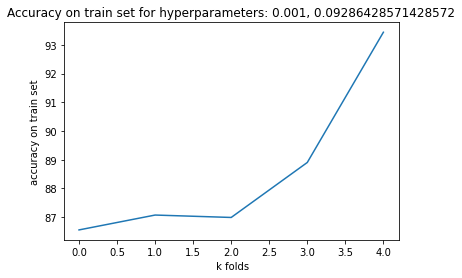

In [48]:
plt.plot(train_acc)
plt.xlabel(" k folds")
plt.ylabel("accuracy on train set")
plt.title("Accuracy on train set for hyperparameters: "+str(best_alpha)+", "+str(best_lamda))
plt.show()

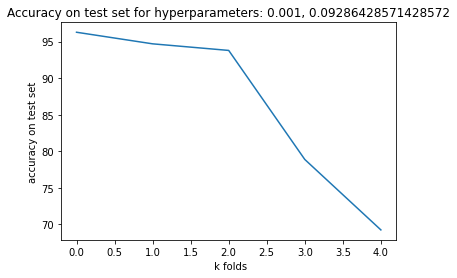

In [49]:
plt.plot(test_acc)
plt.xlabel(" k folds")
plt.ylabel("accuracy on test set")
plt.title("Accuracy on test set for hyperparameters: "+str(best_alpha)+", "+str(best_lamda))
plt.show()

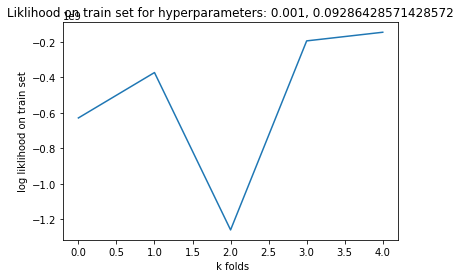

In [50]:
plt.plot(train_lik)
plt.xlabel(" k folds")
plt.ylabel("log liklihood on train set")
plt.title("Liklihood on train set for hyperparameters: "+str(best_alpha)+", "+str(best_lamda))
plt.show()

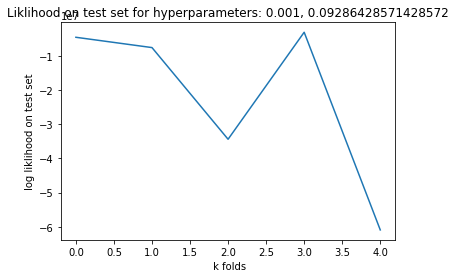

In [51]:
plt.plot(test_lik)
plt.xlabel(" k folds")
plt.ylabel("log liklihood on test set")
plt.title("Liklihood on test set for hyperparameters: "+str(best_alpha)+", "+str(best_lamda))
plt.show()

### Plotting 3-D plot

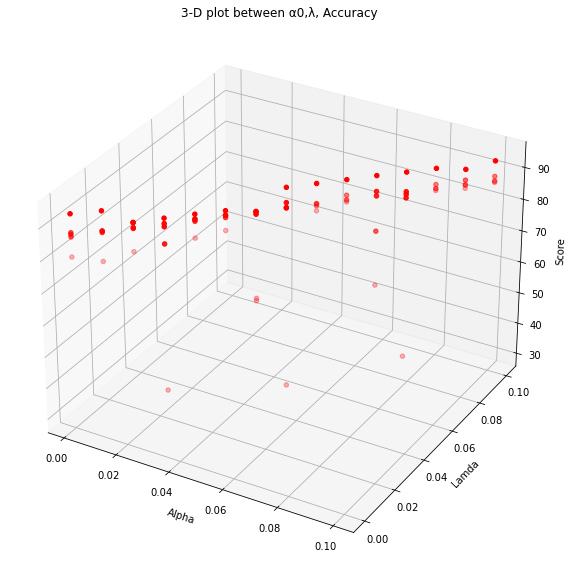

In [82]:
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.view_init(20, 70)



ax = fig.add_subplot(1, 1, 1, projection='3d')

for i in range(len(alphas)):
    ax.scatter(alphas[i], lambdas[i], plot_values[i][i], c='r', marker='o')

# Set axes label
ax.set_xlabel('Alpha')
ax.set_ylabel('Lamda')
ax.set_zlabel('Score')
ax.set_title("3-D plot between α0,λ, Accuracy")
plt.show()


## Exercise 3 : Implementing Hyperband for Logistic Regression

### Split dataset into train, test and validation sets

In [89]:
train, test = train_test_split(bank_df, test_size=0.15, random_state=42, shuffle=True)
train, val = train_test_split(train, test_size=0.15, random_state=42, shuffle=True)

In [124]:
def get_random_hyperparameter_configuration():
    '''
    Returns samples from the hyperparameter configuration space
    '''
    
    alpha = np.random.uniform(0.001, 0.1, size=1)
    lamda = np.random.uniform(0.001, 0.1, size=1)
    batch_size = (np.random.randint(50, 200, size = 1))
    
    return [alpha,lamda,batch_size]

In [110]:
def run_then_return_val_loss(num_iters, hyperparameters):
    alpha = hyperparameters[0]
    lamda = hyperparameters[1]
    batch_size = hyperparameters[2]
    
    num_iters = int(num_iters)
    
    val_loss = learn_logreg(train, val, alpha, lamda, num_iters, batch_size)
    
    return val_loss

def learn_logreg(train, val, alpha, lamda, tmax, batch_size):
    '''
    Implementation of regularized logistic regression with gradient ascent algorithm (maximize log liklihood)
    '''
    (X,Y,X_test,Y_test) = prep_data(train, val, batch_size) 
    # initializing parameter vector
    params = np.zeros((len(X[0]),1))
    
    for i in range(tmax):
        
        # Do forward pass
        interm_val = np.matmul(X,params)
        Y_hat = 1/(1+np.exp(-interm_val))
        
        gradient = np.matmul(X.T, (Y - Y_hat)) - (2*lamda*params) ## the regularized term
        
        # Update params
        params = params + alpha*gradient
    
    
    interm_val = np.matmul(X_test,params)
    Y_hat = 1/(1+np.exp(-interm_val))
    val_loss = -np.mean((Y_test*np.log(Y_hat)) + (1-Y_test)*(np.log(1-Y_hat)))
    
    
    return val_loss

In [165]:
def hyperband(R, eta):
    '''
    Implementation of Hyperband - a hyperparameter optimization algorithm
    '''
    s_max = int(np.log(R)/np.log(eta))
    B = (s_max+1)*R

    for s in reversed(range(s_max+1)):
        n = int(np.ceil(int(B/R/(s+1))*eta**s)) 
        r = R*eta**(-s) 

    
        T = [ get_random_hyperparameter_configuration() for i in range(n) ] 
        for i in range(s+1):
        
            n_i = n*eta**(-i)
            r_i = r*eta**(i)
            for t in T:
                t.append([run_then_return_val_loss(num_iters=r_i,hyperparameters=t)])
            
            
            # Sort by validation losses
            T = sorted(T, key = lambda x: x[3])
            
            T = T[0:int( n_i/eta )]
            
    return T

### Optimal hyper-parameters received from Hyperband algorithm

In [173]:
## Hyperparameters for hyperband
R = 150
eta = 4

hyper_params = hyperband(R, eta)

alpha = hyper_params[0][0]
lamda = hyper_params[0][1]
batch_size = hyper_params[0][2]

### Training the model and get loss on test set

In [174]:
test_loss = learn_logreg(train, test, alpha, lamda, 150, batch_size)
print(test_loss)

0.35628857922164175
